In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import numpy as np

import GPyOpt

import argparse

from utils import tf_config, preprocess_data, search_algorithms, train, losses_utils, metrics, bnn_utils

from models import fmri_ae, eeg_to_fmri, uniconv_fmri

from layers import locally_connected, fourier_features

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

import time

dataset="01"
memory_limit=1500
n_individuals=10
interval_eeg=10

tf_config.set_seed(seed=42)
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

with tf.device('/CPU:0'):
    train_data, _ = preprocess_data.dataset(dataset, n_individuals=n_individuals,
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    eeg_train, fmri_train =train_data

2021-12-20 16:23:08.530339: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-20 16:23:12.572387: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-20 16:23:12.578255: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-20 16:23:12.637975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 16:23:12.638915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce MX150 computeCapability: 6.1
coreClock: 1.5315GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 44.76GiB/s
2021-12-20 16:23:12.639008: I tensorflow/stream_executor/platform/default/dso_l

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


In [2]:
eeg_train = eeg_train[:100]
fmri_train = fmri_train[:100]

In [3]:
theta = (0.002980911194116198, 0.0004396489214334123, (9, 9, 4), (1, 1, 1), 1, (7, 7, 7), 4, True, True, True, True, 3, 1)
#unroll hyperparameters
learning_rate=float(theta[0])
weight_decay = float(theta[1])
kernel_size = theta[2]
stride_size = theta[3]
batch_size=int(theta[4])
latent_dimension=theta[5]
n_channels=int(theta[6])
max_pool=bool(theta[7])
batch_norm=bool(theta[8])
skip_connections=bool(theta[9])
dropout=bool(theta[10])
n_stacks=int(theta[11])
outfilter=int(theta[12])
local=True
na_specification = ([(10,20,2),(10,20,2)], 
                    [(1,1,1),(1,1,1)],
                   True,
                   (2,2,1),
                   (1,1,1))

In [4]:
import importlib
importlib.reload(eeg_to_fmri)

low_resolution_factor=2
resolution_decoder = (int(fmri_train.shape[1]/low_resolution_factor),
                     int(fmri_train.shape[2]/low_resolution_factor),
                     int(fmri_train.shape[3]/low_resolution_factor))

with tf.device('/CPU:0'):
    model = eeg_to_fmri.EEG_to_fMRI(latent_dimension, eeg_train.shape[1:], na_specification, 4,
                        weight_decay=0.000, skip_connections=True,
                        batch_norm=True, #dropout=False,
                        fourier_features=True,
                        random_fourier=True,
                        inverse_DFT=False, DFT=False,
                        variational_iDFT=False,
                        variational_coefs=(15,15,15),
                        low_resolution_decoder=False,
                        resolution_decoder=resolution_decoder,#experimenting
                        local=True, seed=None, 
                        fmri_args = (latent_dimension, fmri_train.shape[1:], 
                        kernel_size, stride_size, n_channels, 
                        max_pool, batch_norm, weight_decay, skip_connections,
                        n_stacks, True, False, outfilter, dropout, None, False, None))
    
    model.build(eeg_train.shape, fmri_train.shape)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn = losses_utils.mae_cosine

    train_set = tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(batch_size)
    dev_set= tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(1)

In [7]:
loss_history = train.train(train_set, model, optimizer, 
                            loss_fn, epochs=1, 
                            u_architecture=True,
                            val_set=None, verbose=True, verbose_batch=False)[0]

2021-12-20 16:26:00.337548: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-20 16:26:00.365706: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


Epoch 1 with loss: 0.5831339523196221


## Propagating Relevances

In [8]:
from utils import lrp
importlib.reload(lrp)

for instance_x, instance_y in train_set.repeat(1):
    d_ = model.decoder
    e_ = model.eeg_encoder
    
    encoder_activations = []
    decoder_activations = []
    
    z = instance_x
    #forward pass
    for layer in e_.layers:
        z = layer(z)
        encoder_activations += [z]
    
    for layer in d_.layers:
        z = layer(z)
        decoder_activations += [z]
    
    R = decoder_activations[-1]
    print(tf.reduce_sum(R))
    #propagate through decoder
    for layer in range(len(d_.layers))[::-1]:
        if(hasattr(d_.layers[layer], "lrp")):
            R = d_.layers[layer].lrp(decoder_activations[layer-1, R])
        else:
            
            if(layer-1 >= 0):
                R = lrp.lrp(decoder_activations[layer-1], R, d_.layers[layer])
            else:
                R = lrp.lrp(encoder_activations[-1], R, d_.layers[layer])
                
        print(tf.reduce_sum(R))
        
                
    #propagate through encoder
    for layer in range(len(e_.layers))[::-1]:
        if(hasattr(e_.layers[layer], "lrp")):
            R = e_.layers[layer].lrp(encoder_activations[layer-1], R)
        else:
            
            if(layer-1 >= 0):
                R = lrp.lrp(encoder_activations[layer-1], R, e_.layers[layer])
            else:
                R = lrp.lrp(instance_x, R, e_.layers[layer])
        print(tf.reduce_sum(R))
                
    print(R.shape)
    print(tf.reduce_sum(R))
    break


tf.Tensor(8540.785, shape=(), dtype=float32)
conv3d_15
tf.Tensor(13586.498, shape=(), dtype=float32)
reshape_2
tf.Tensor(13586.498, shape=(), dtype=float32)
dense_1
tf.Tensor(15485.196, shape=(), dtype=float32)
flatten_2
tf.Tensor(15485.196, shape=(), dtype=float32)
input_3
tf.Tensor(15485.196, shape=(), dtype=float32)
reshape_1
tf.Tensor(15485.196, shape=(), dtype=float32)
tf.Tensor(-52633.785, shape=(), dtype=float32)
flatten_1
tf.Tensor(-52633.785, shape=(), dtype=float32)
re_lu_14
add_4
re_lu_13
conv3d_13
re_lu_12
max_pooling3d_8
conv3d_12
max_pooling3d_9
conv3d_14
tf.Tensor(-62695.438, shape=(), dtype=float32)
re_lu_11
add_3
re_lu_10
conv3d_10
re_lu_9
max_pooling3d_6
conv3d_9
max_pooling3d_7
conv3d_11
tf.Tensor(-189857.0, shape=(), dtype=float32)
input_2
tf.Tensor(-189857.0, shape=(), dtype=float32)
(1, 64, 134, 10, 1)
tf.Tensor(-189857.0, shape=(), dtype=float32)


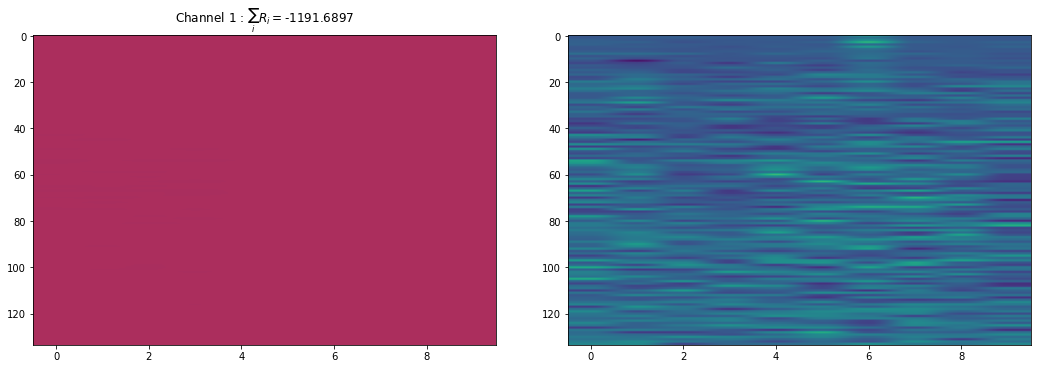

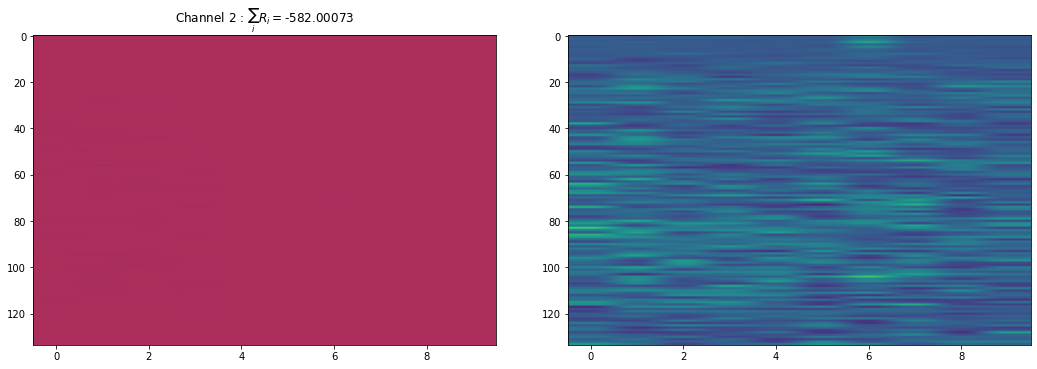

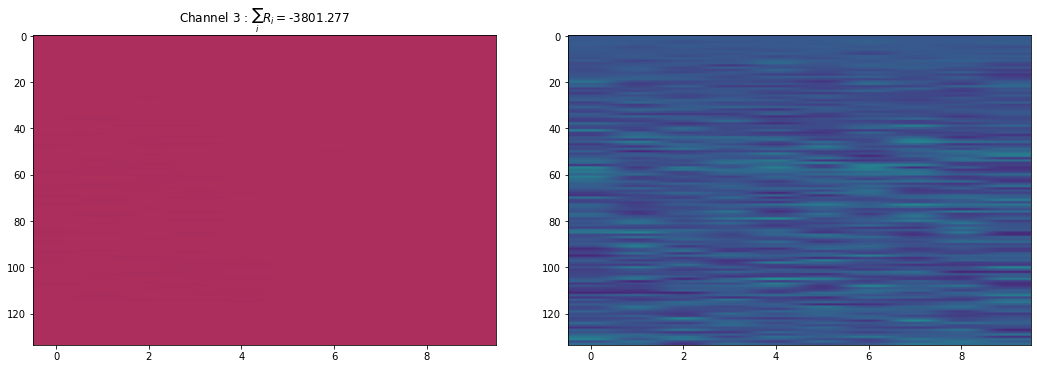

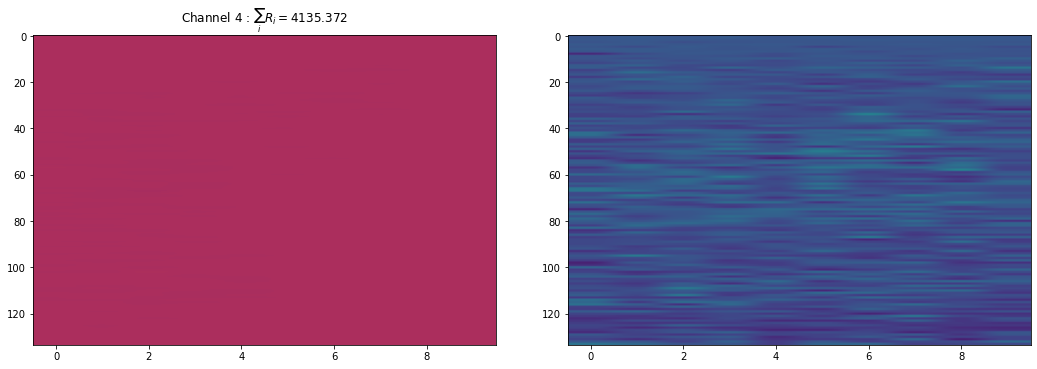

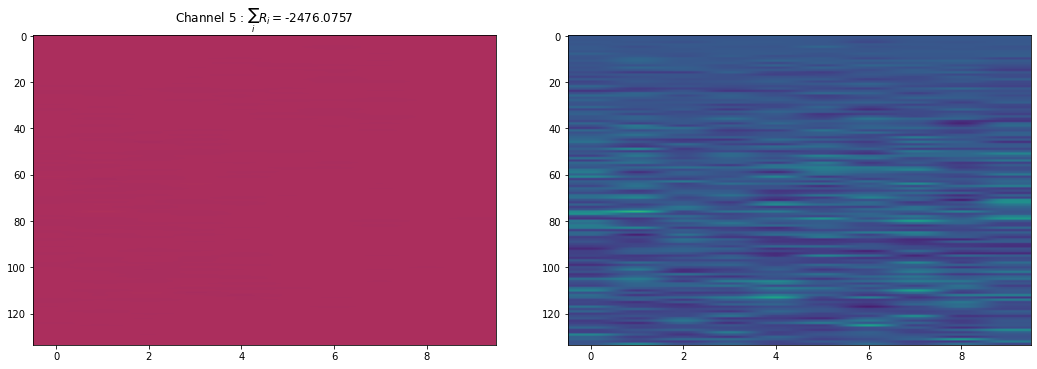

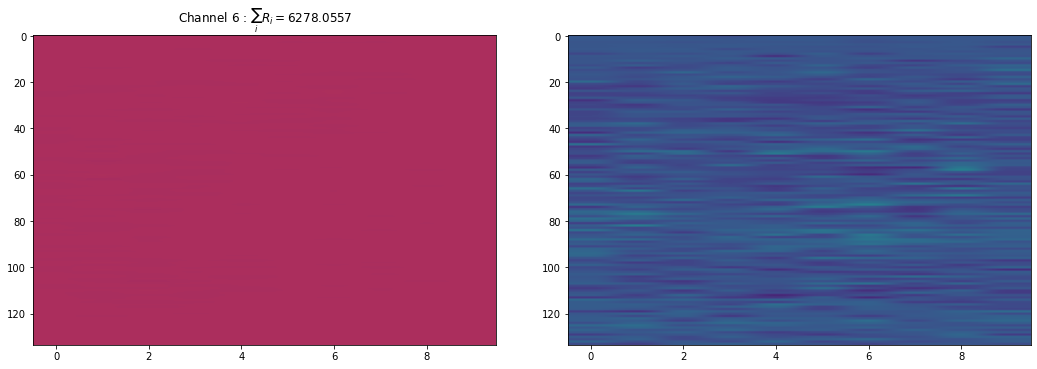

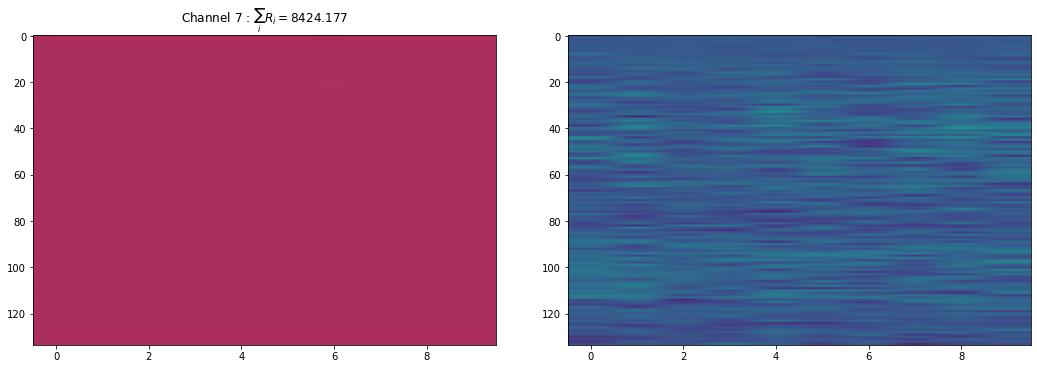

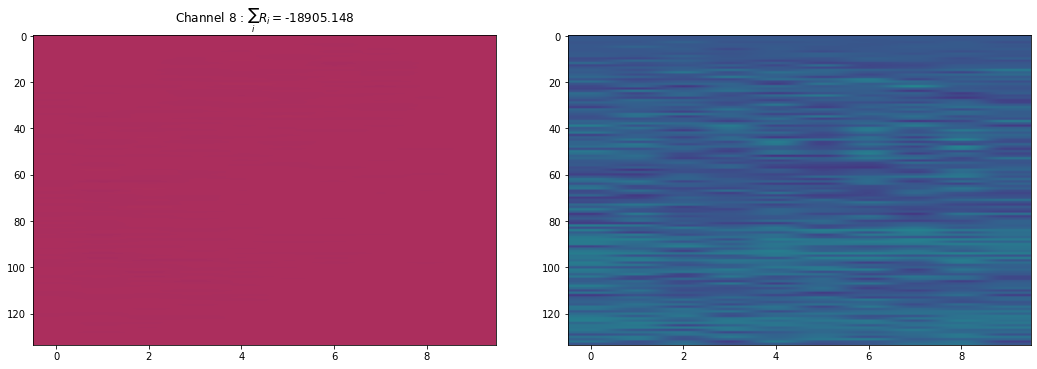

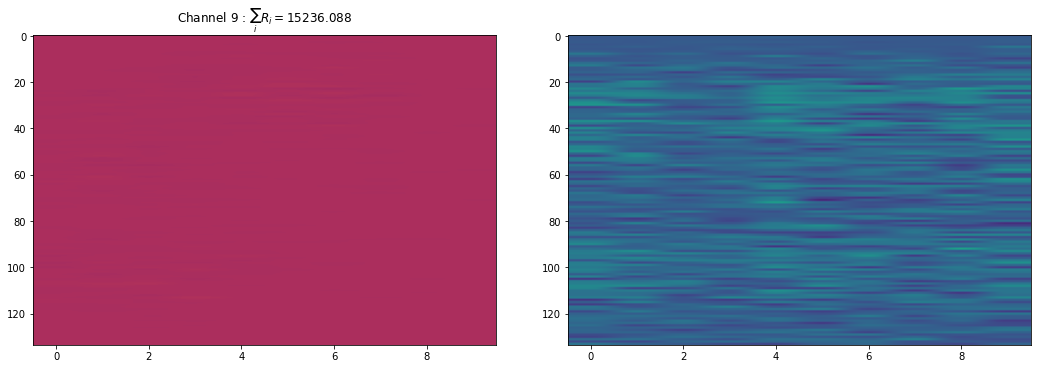

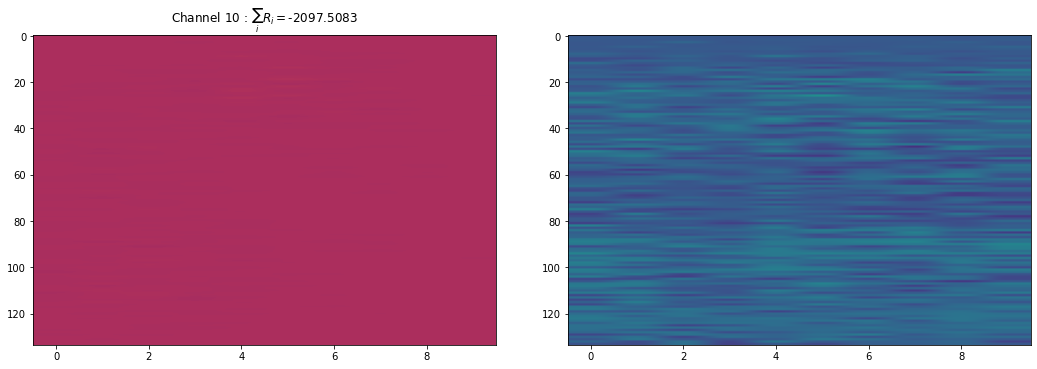

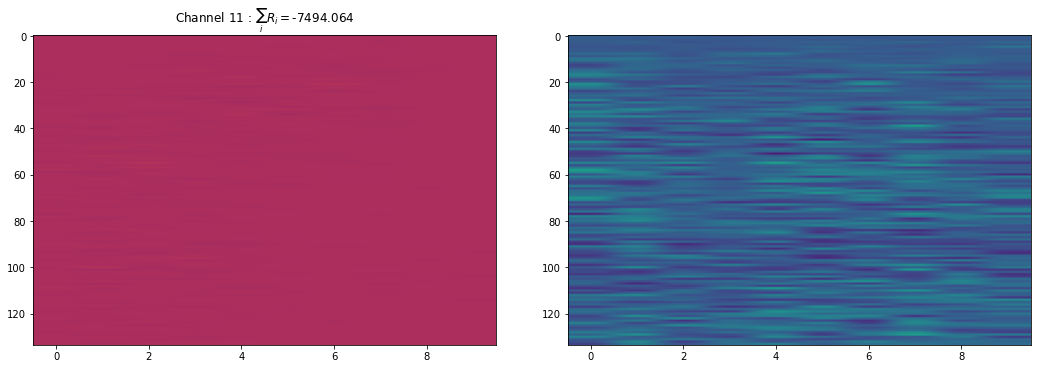

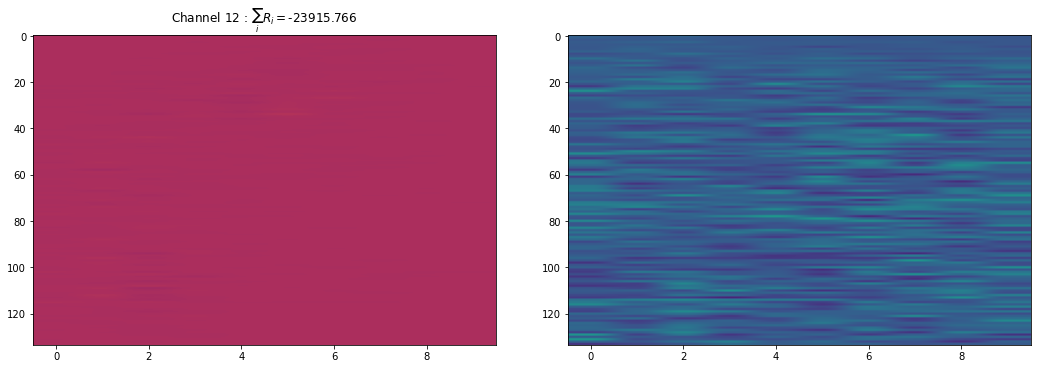

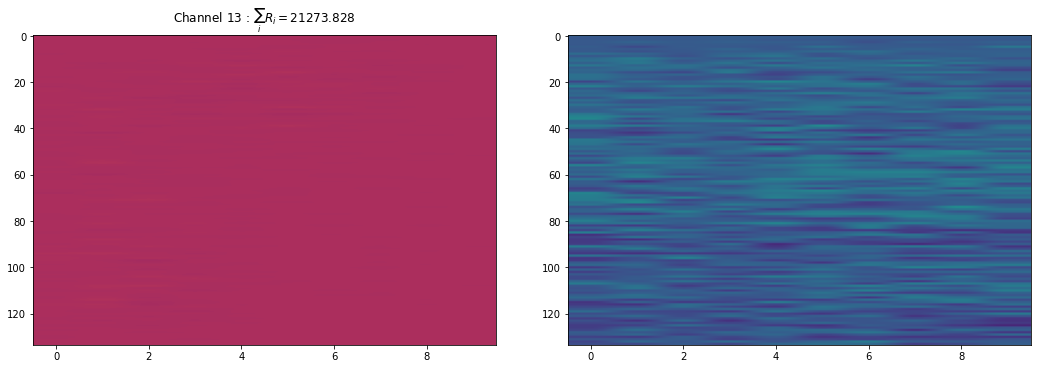

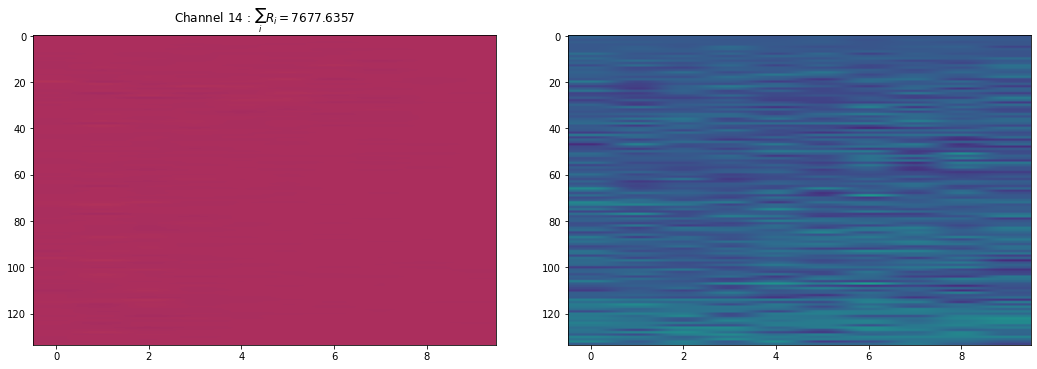

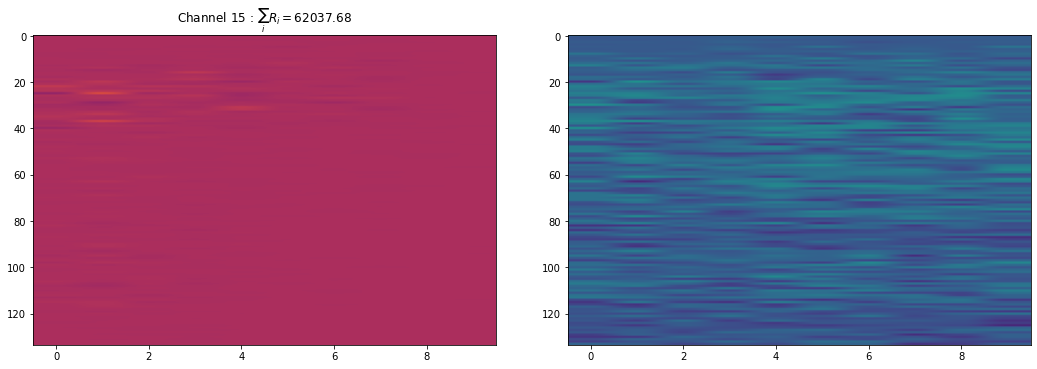

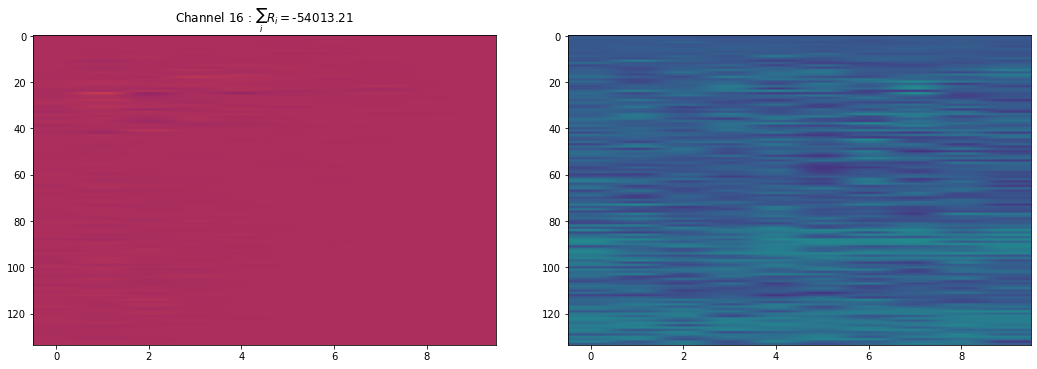

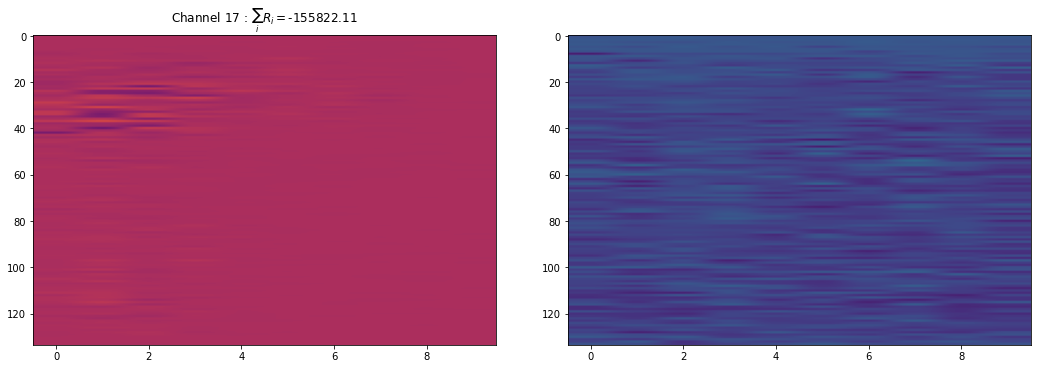

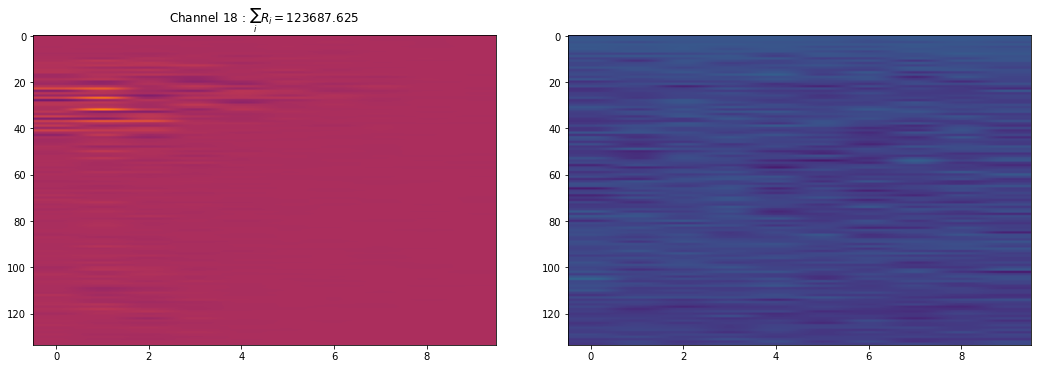

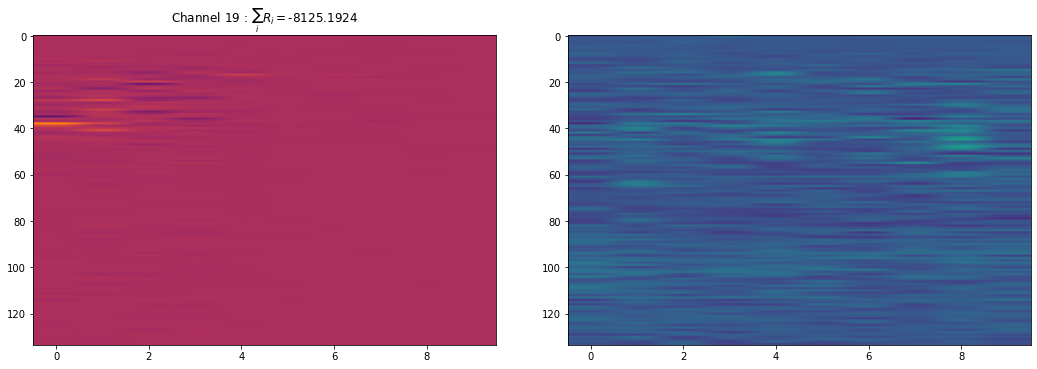

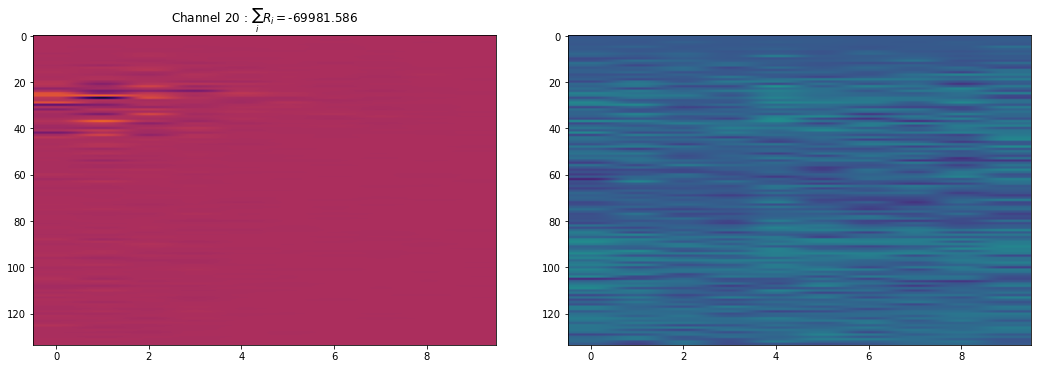

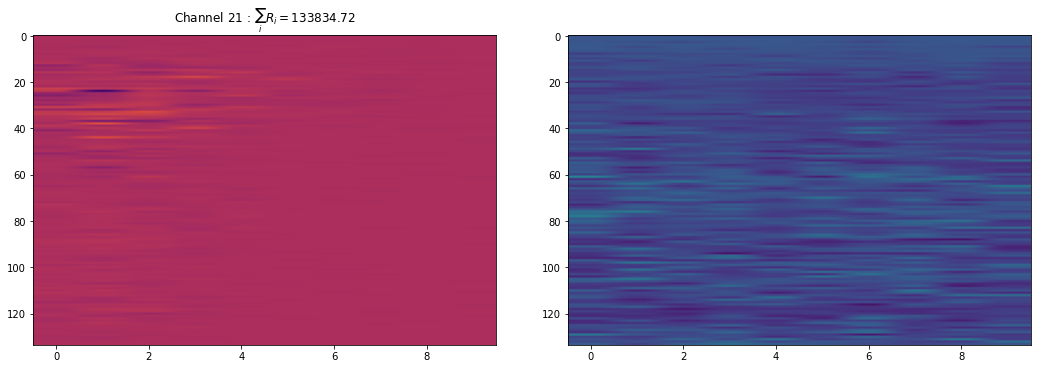

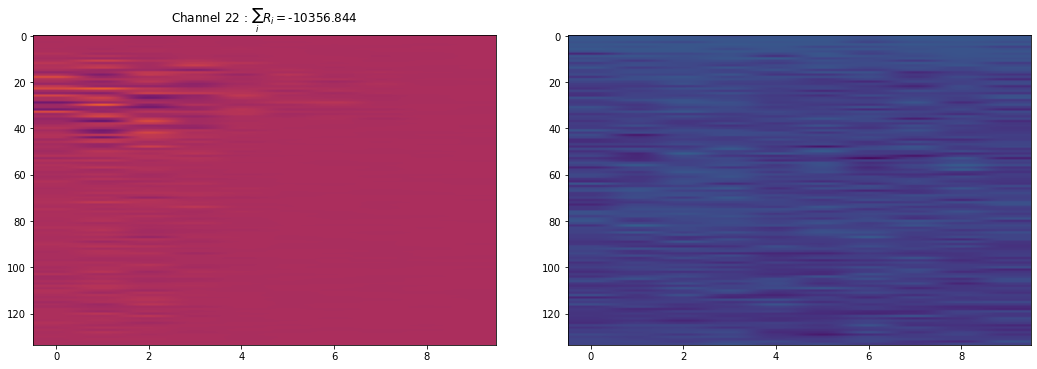

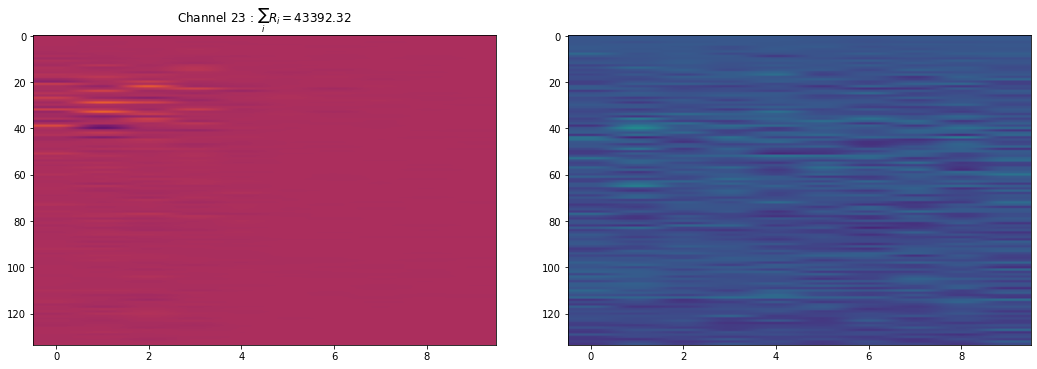

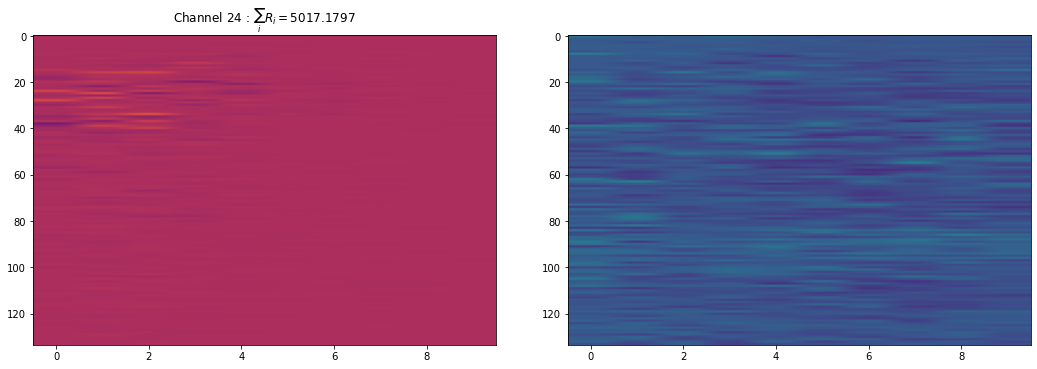

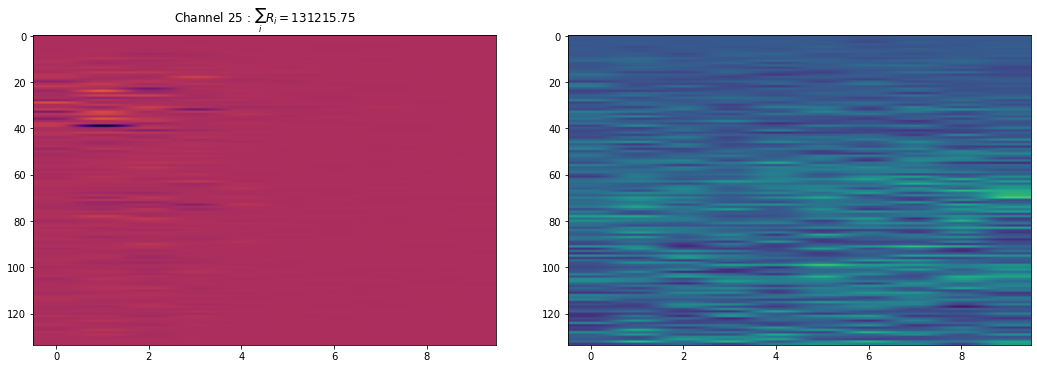

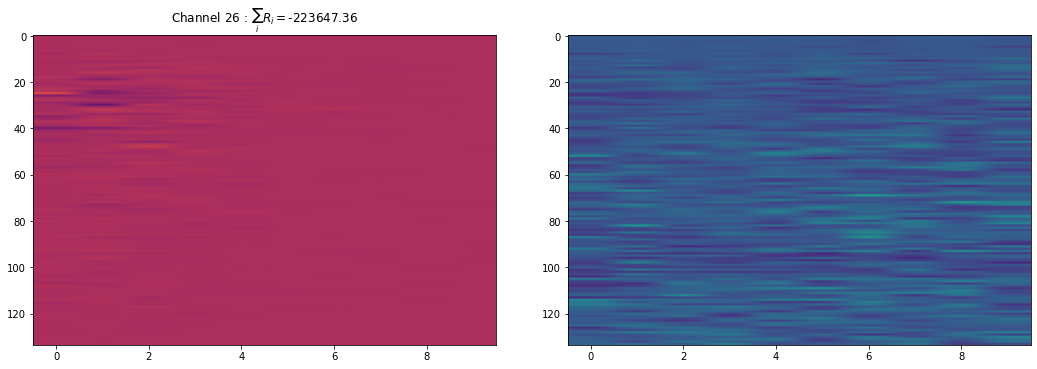

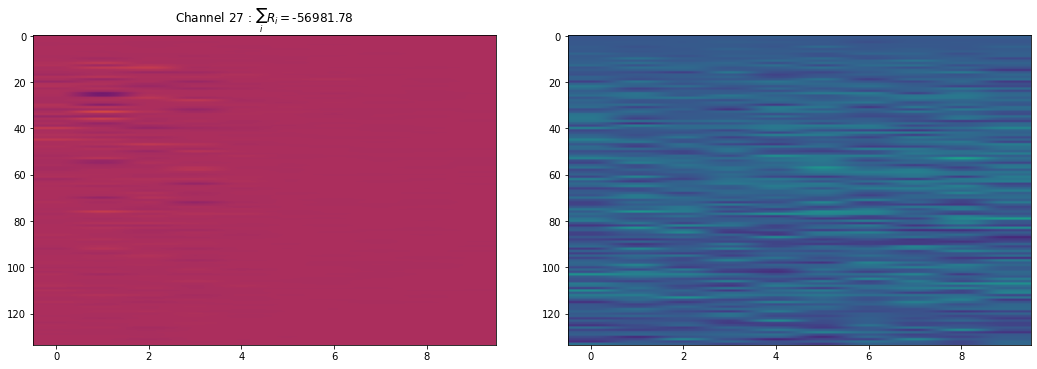

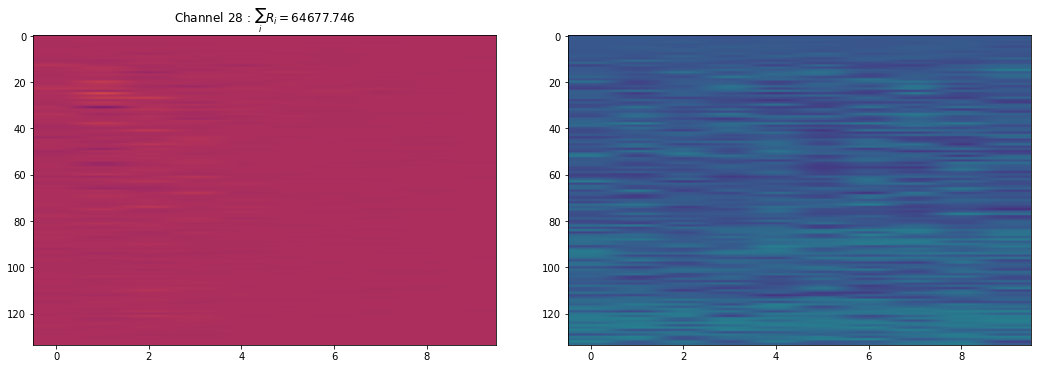

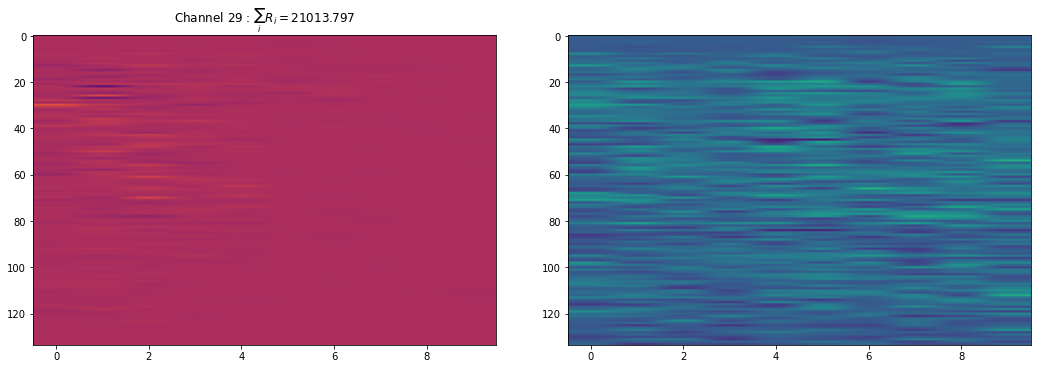

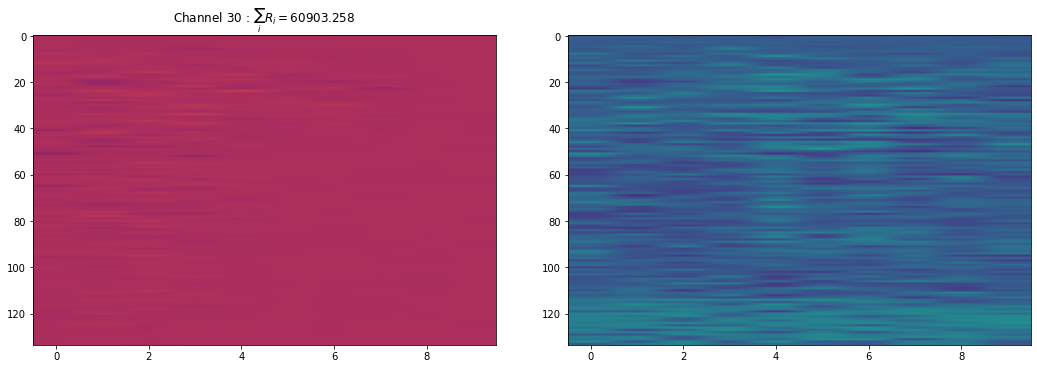

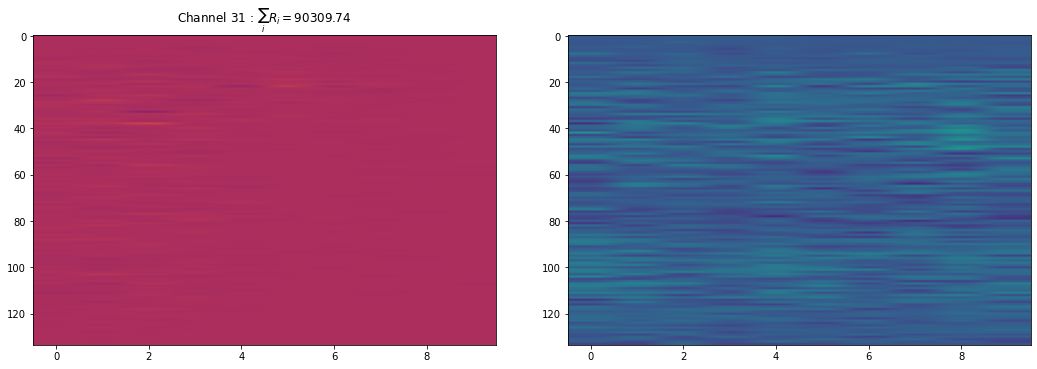

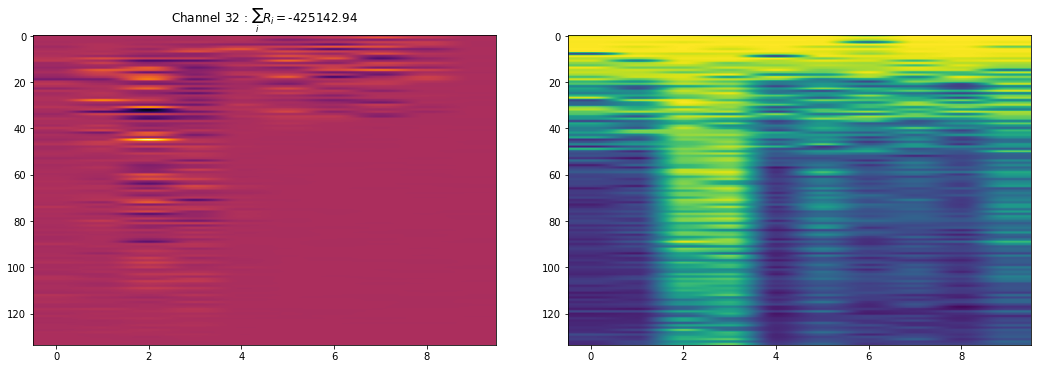

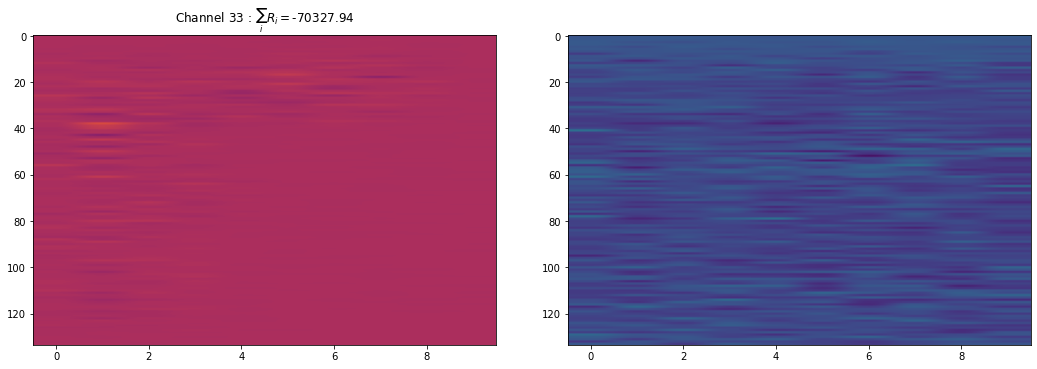

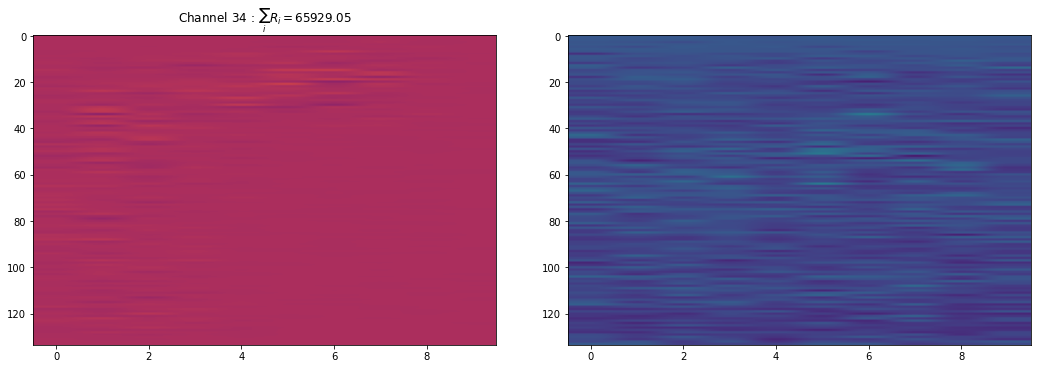

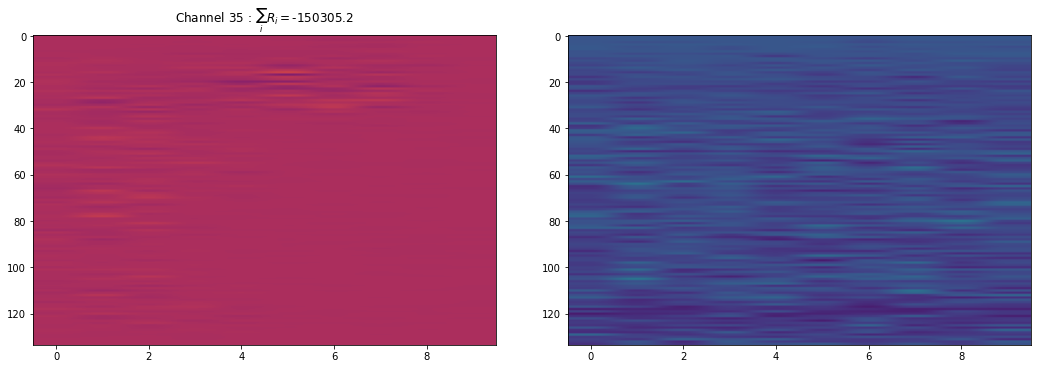

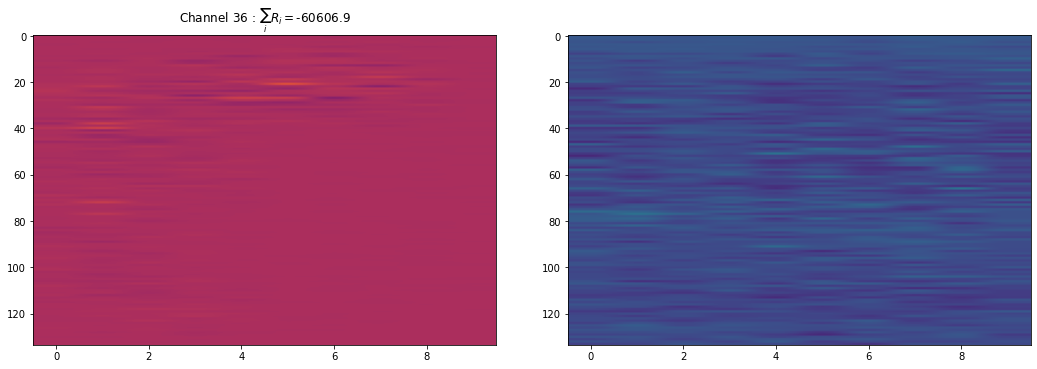

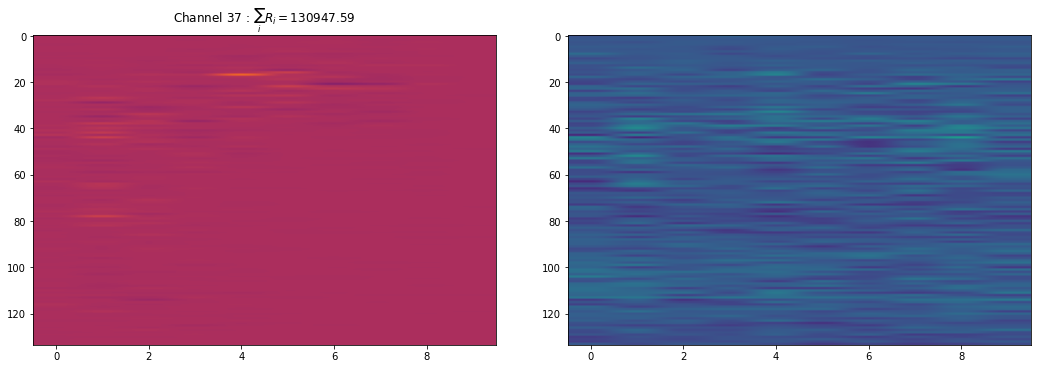

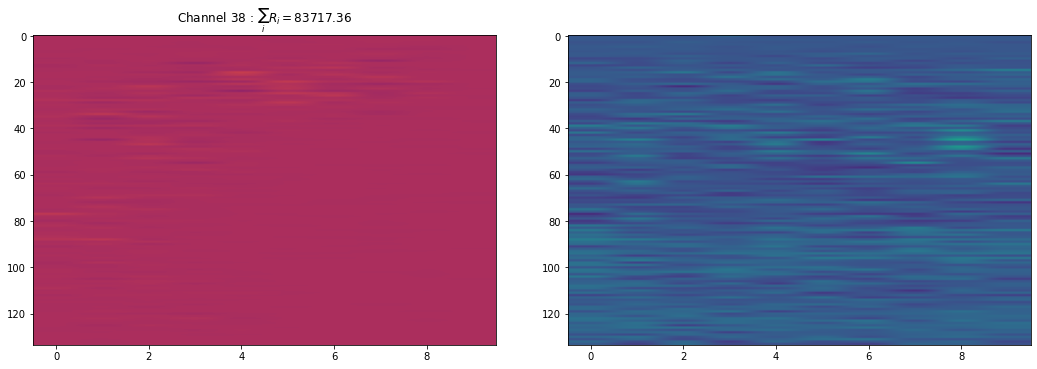

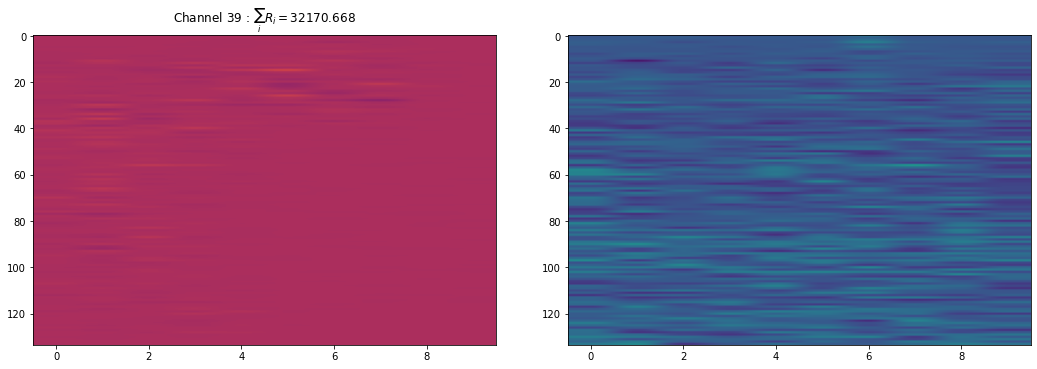

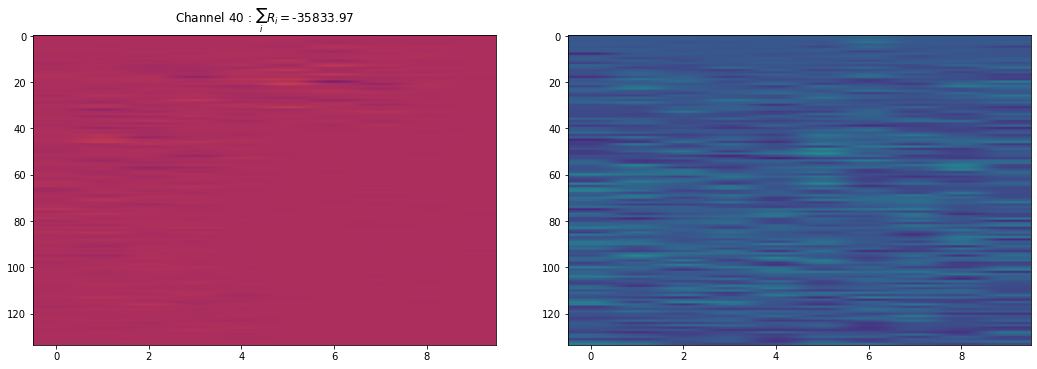

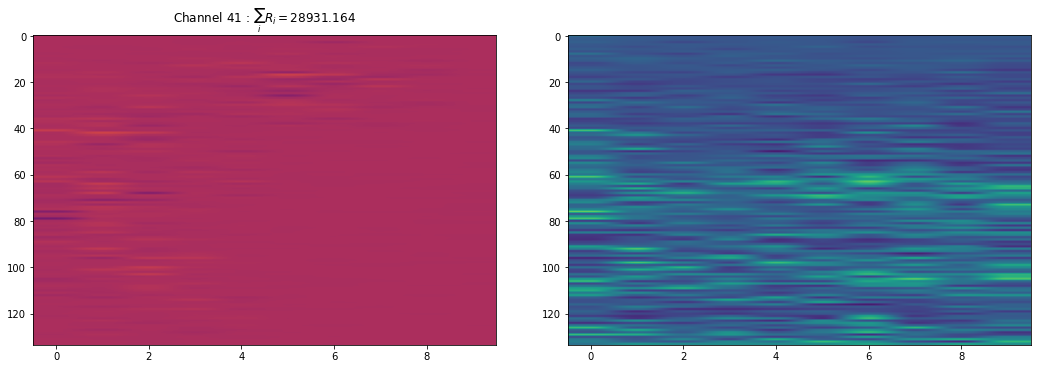

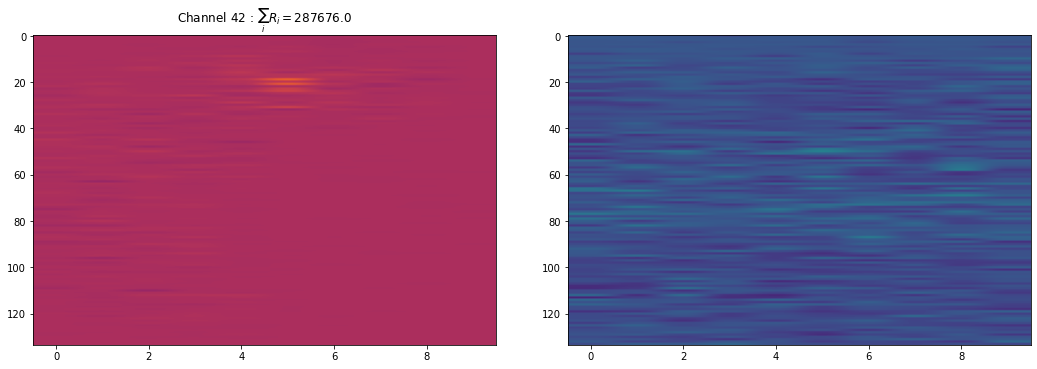

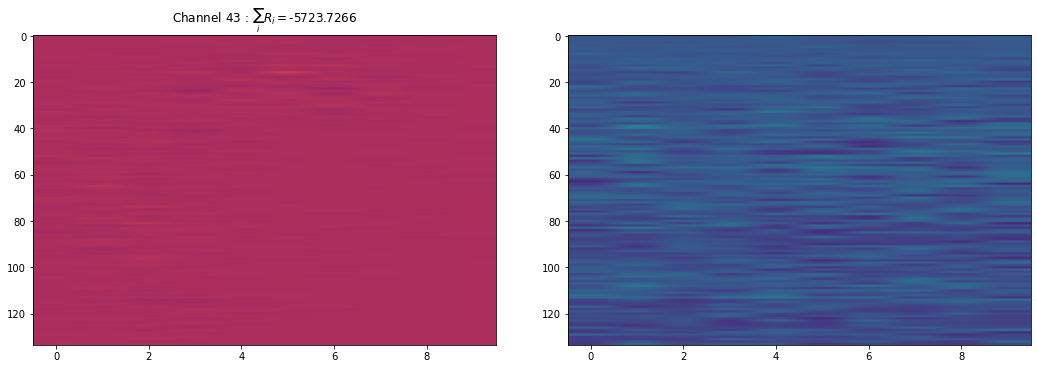

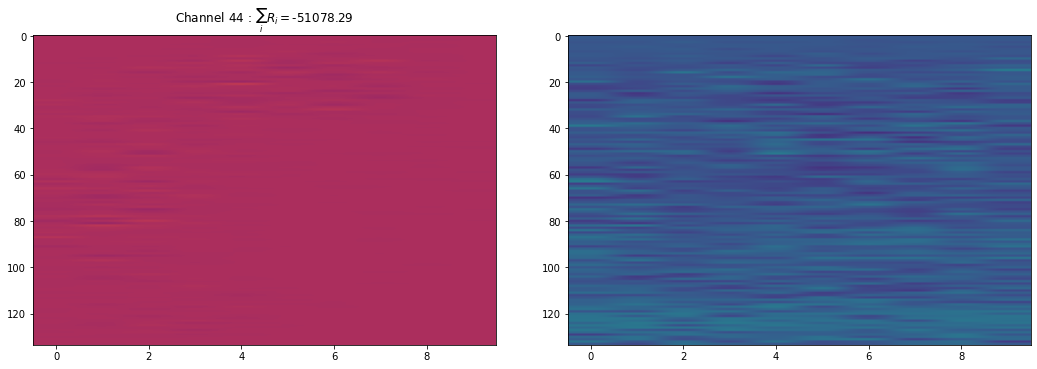

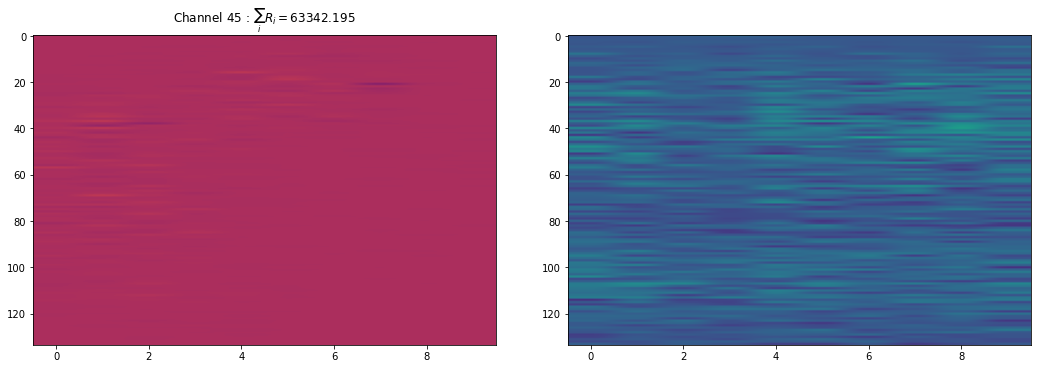

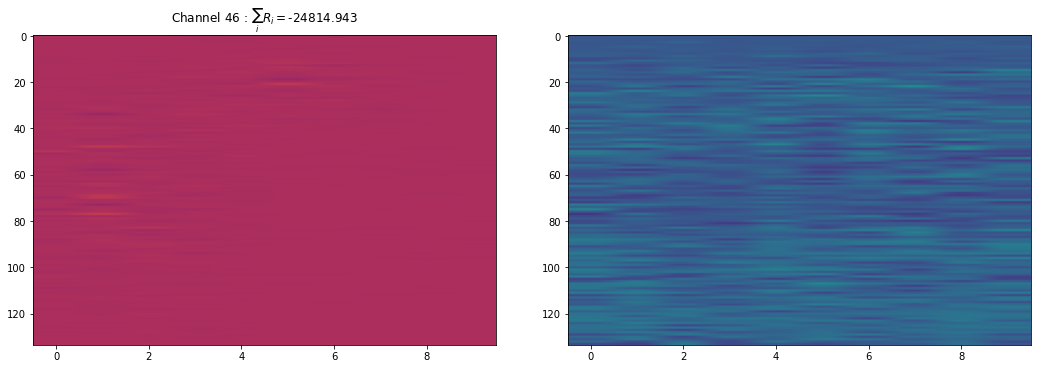

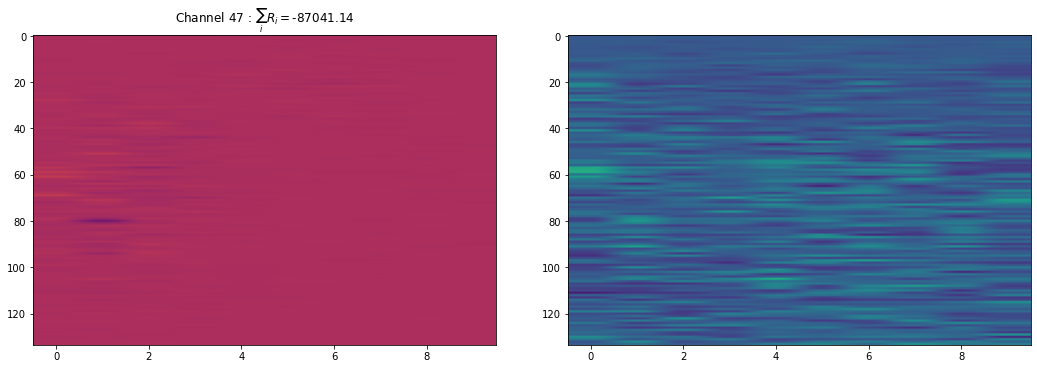

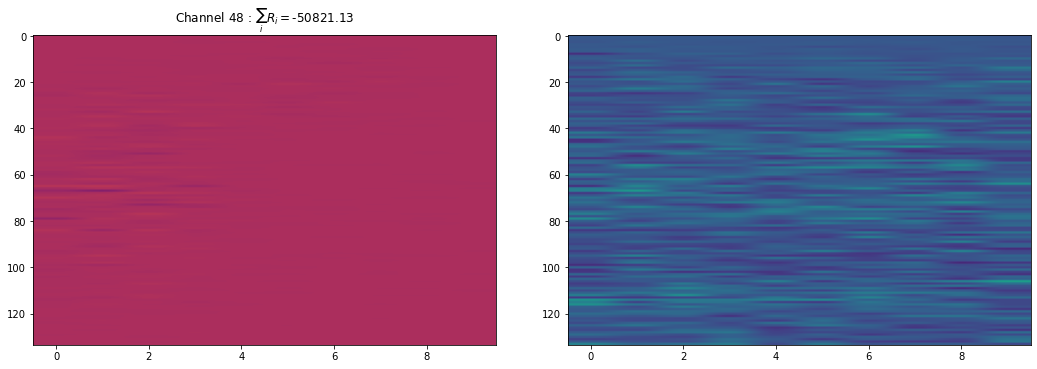

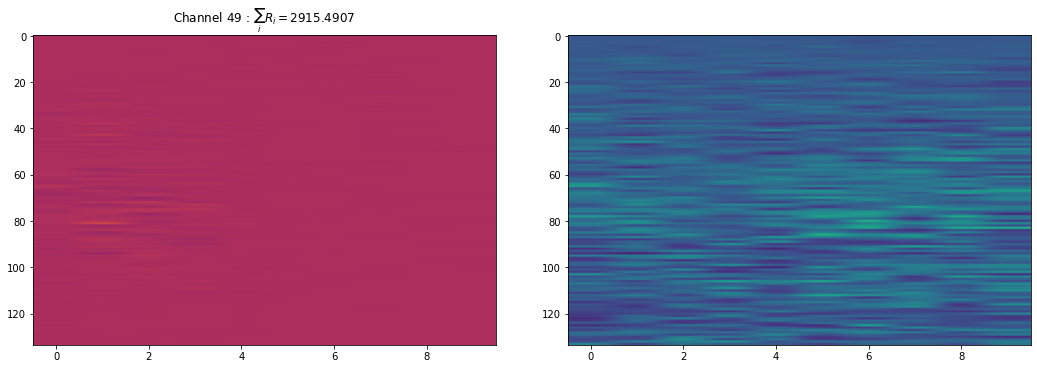

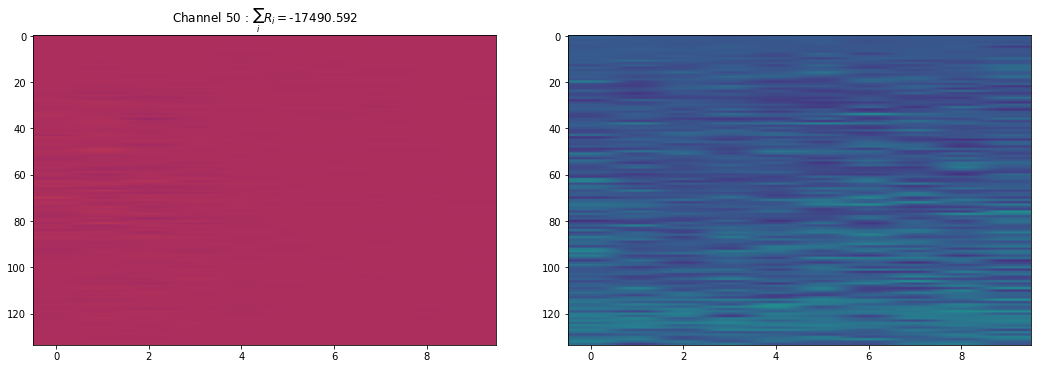

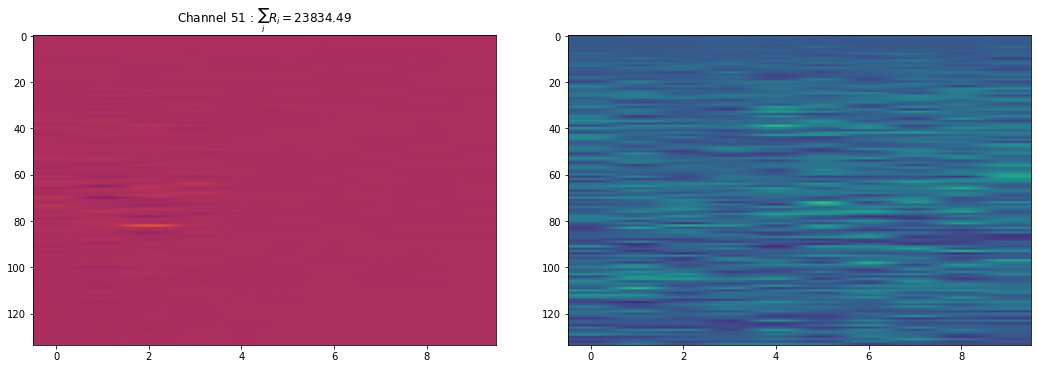

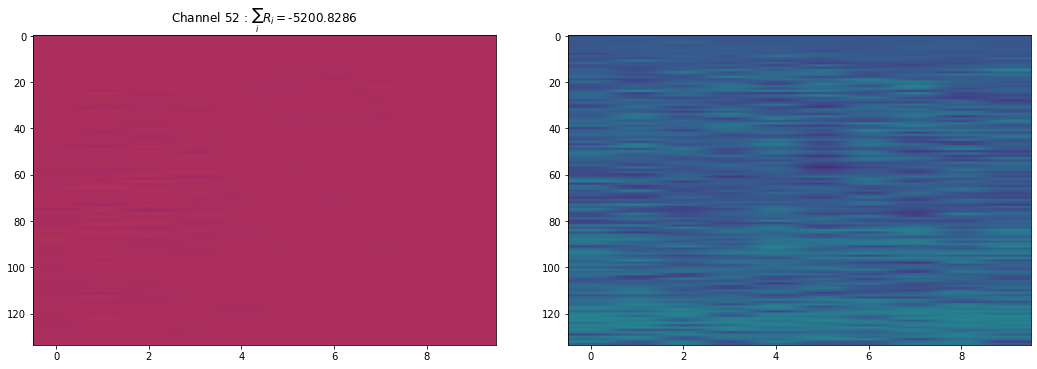

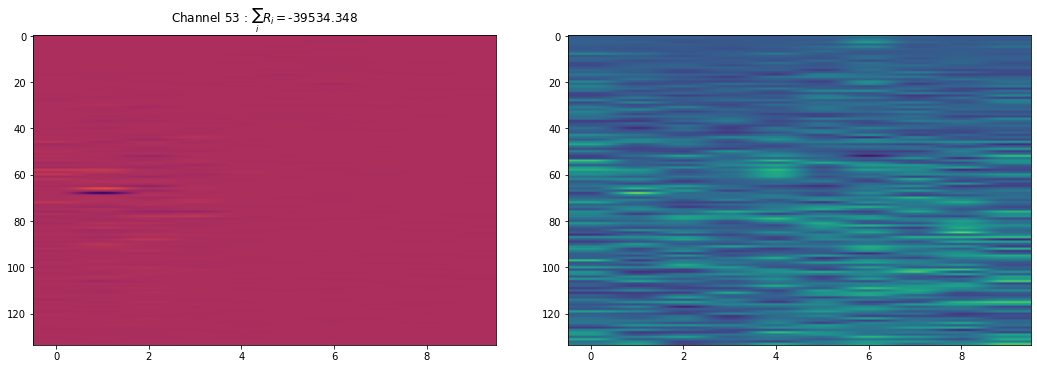

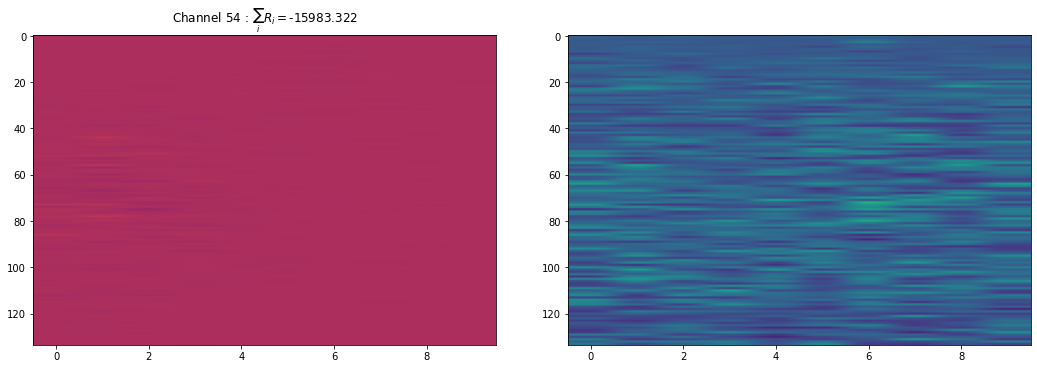

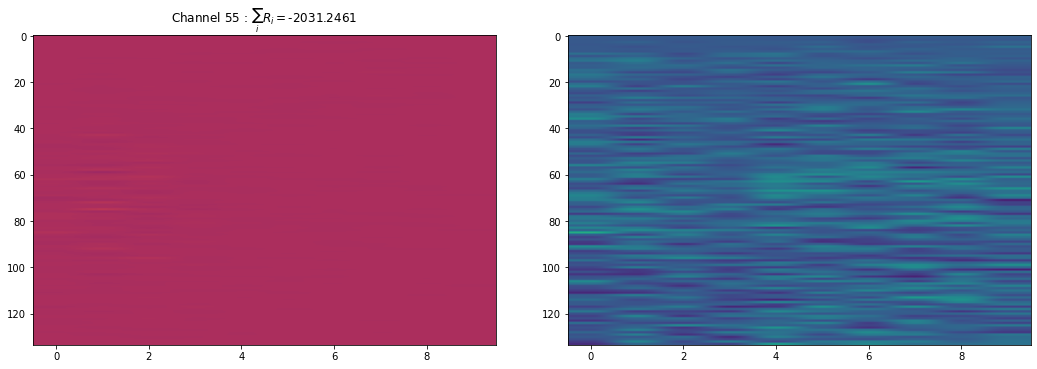

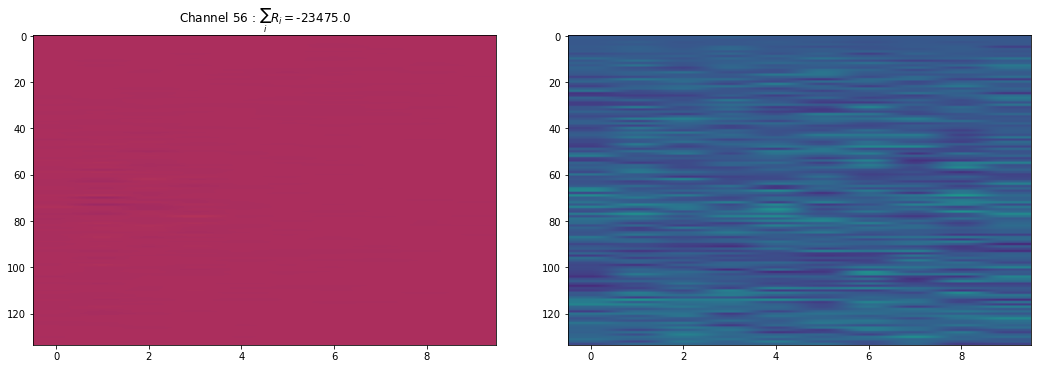

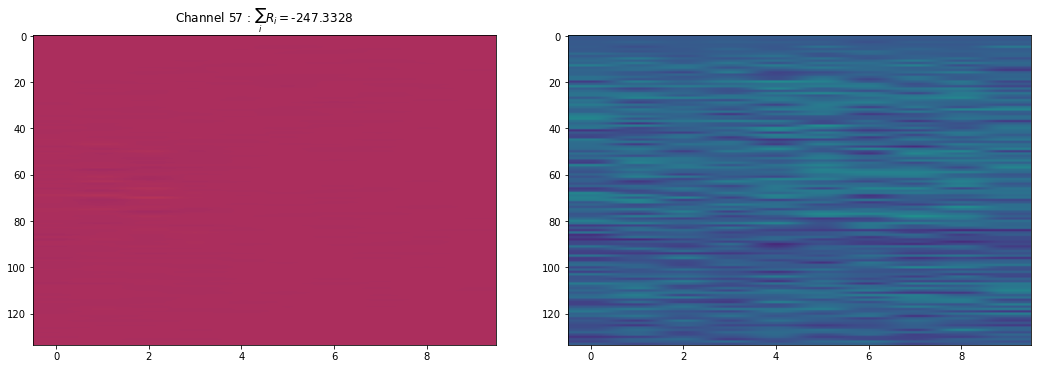

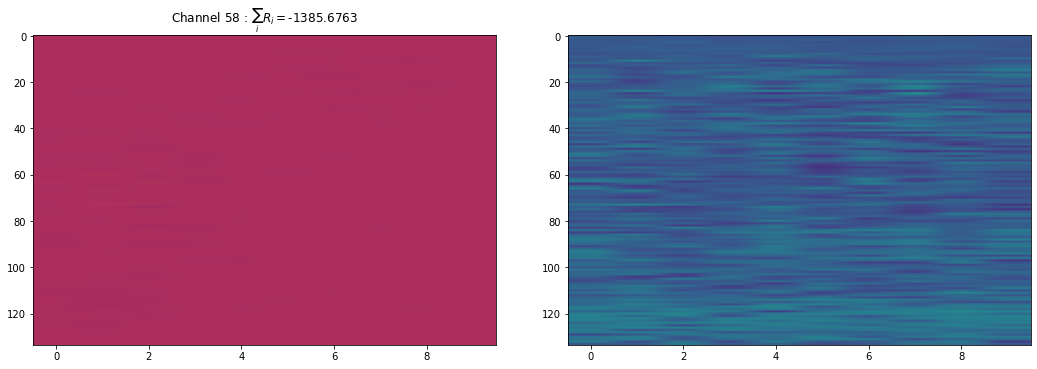

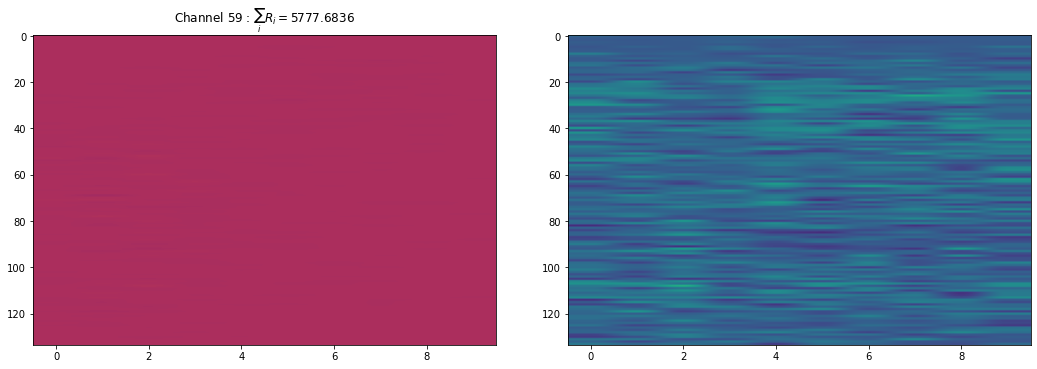

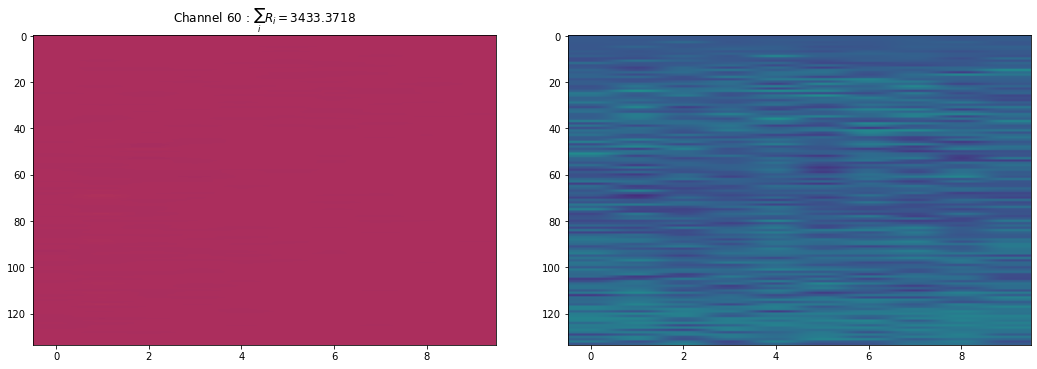

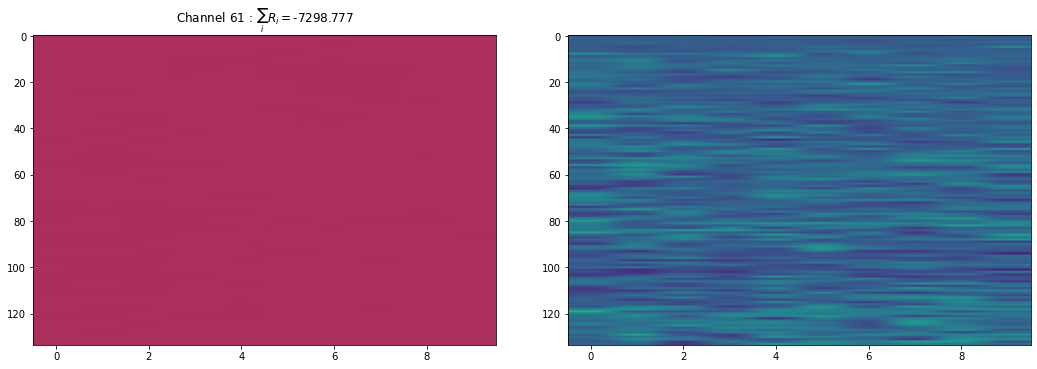

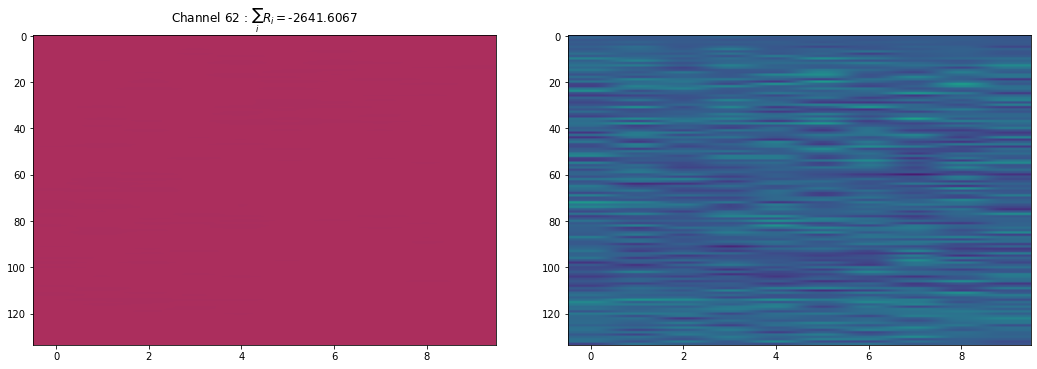

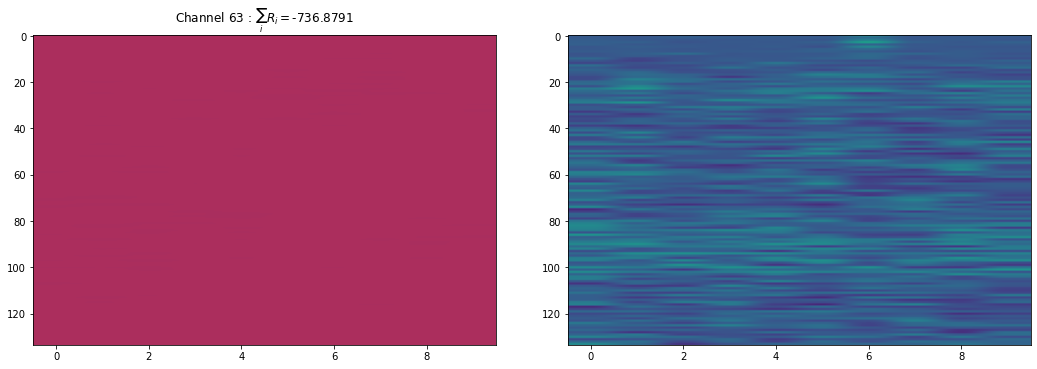

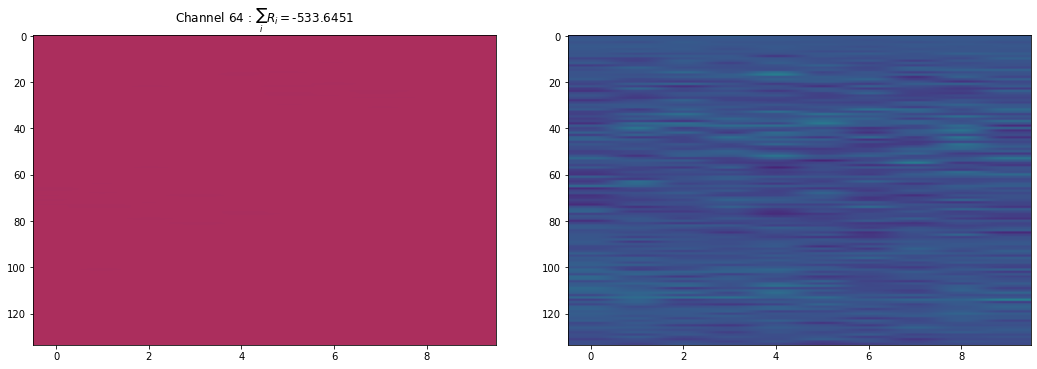

In [33]:




for channel in range(R.shape[1]):
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].imshow(R[0,channel,:,:,0].numpy(), 
               cmap=plt.cm.inferno,
                vmin=np.amin(R.numpy()),
                vmax=np.amax(R.numpy()),
               aspect=0.05)
    axes[0].set_title("Channel "+str(channel+1)+" : "+r"$\sum_i R_i = $"+str(np.sum(R[0,channel,:,:,0].numpy())))
    axes[1].imshow(instance_x[0, channel,:,:,0].numpy(),
                  aspect=0.05,
                  vmin=np.amin(eeg_train),
                vmax=np.amax(eeg_train))
    fig.tight_layout()
    fig.show()
    

In [28]:
str(np.sum(R[0,0,:,:,0].numpy()))

'-1191.6897'

In [ ]:
import importlib
importlib.reload(eeg_to_fmri)